In [332]:
import pandas as pd
import numpy as np
import time as timer
import matplotlib.pyplot as plt

from itertools import product
from scipy.integrate import solve_ivp
import matplotlib.dates as mdates
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# SEIR Model Equations

The SEIR model is defined by the following system of differential equations:


\begin{aligned}
\frac{dS}{dt} &= \mu N -\frac{\beta S I}{N} + \omega R - \mu S \\
\frac{dE}{dt} &= \frac{\beta S I}{N} - \sigma E - \mu E  \\
\frac{dI}{dt} &= \sigma E - \gamma I - (\mu + \alpha)I \\
\frac{dR}{dt} &= \gamma I - \omega R - \mu R
\end{aligned}


Where:
- $ S $: Susceptible population
- $ E $: Exposed population (infected but not yet infectious)
- $ I $: Infectious population
- $ R $: Recovered population
- $\beta$: Transmission rate, the rate at which susceptible individuals become exposed.
- $\sigma$: Rate at which exposed individuals become infectious ($1/\text{latent period}$).
- $\gamma$: Recovery rate ($1/\text{infectious period}$).
- $\mu$: Background death rate, representing mortality from causes other than the disease.
- $\alpha$: Disease-induced death rate, representing additional mortality caused by the disease.
- $\omega$: Immunity loss rate, the rate at which recovered individuals lose immunity and return to the susceptible group.
- $ N $: Total population size ($N = S + E + I + R$).

---

### Key Dynamics

- **Latent Period:** Infected individuals first move to the exposed group ($E$) at a rate proportional to $\frac{\beta S I}{N}$. They remain in this group for an average period of $1/\sigma$ before becoming infectious ($I$).
- **Temporary Immunity:** After recovery, individuals return to the susceptible group ($S$) after an average protected period of $1/\omega$.
- **Demography:** All compartments are influenced by background death at a rate $\mu$, with births replenishing the susceptible population. Disease-induced deaths reduce the infectious population at a rate $\alpha$.


## Parameters and Initialization Overview

### Initial Conditions
- **Susceptible ($S_0$):** Initial proportion of the population at risk.
- **Exposed ($E_0$):** Initial proportion exposed but not yet infectious.
- **Infectious ($I_0$):** Initial proportion infectious.
- **Recovered ($R_0$):** Initial proportion immune or recovered.

### Effects of Parameter Changes
- **Higher $\beta$:** Faster spread, earlier peak.
- **Higher $\sigma$:** Shorter latency, quicker epidemic dynamics.
- **Higher $\gamma$:** Faster recovery, lower peak infectious population.
- **Higher $\omega$:** Faster loss of immunity, leading to a larger susceptible population and potential reinfections.
- **Higher $\mu$:** Higher background death rate, decreasing the total population size and slowing epidemic growth due to reduced susceptibles.
- **Higher $\alpha$:** Increased disease-induced mortality, reducing the infectious population and increasing the severity of the disease's impact.


This setup defines the SEIR model dynamics and how parameters influence epidemic behavior.


In [187]:
## Parameters ---- Initializing with random values at this point
#
beta = 0.7     # Infection rate
sigma = 1/5    # Incubation rate (1/average latent period)
gamma = 1/7    # Recovery rate (1/average infectious period)
omega = 1/180  # Immunity loss rate (1/average duration of immunity)
mu = 1/(70*365) # Background death rate (assuming an average lifespan of 70 years)
alpha = 0.01   # Disease-induced death rate
dt = 1       # Time step
t_max = 365   # Maximum time

## Initial conditions
#
S0, E0, I0, R0 = 0.99, 0.01, 0, 0  # Initial proportions of S, E, I, R
X0 = np.array([S0, E0, I0, R0])   # Initial state vector

## Time array
#
time = np.arange(0, t_max, dt)   # Time steps for simulation

### The Dynamics Matrix $A(\mathbf{X})$

The matrix $A(\mathbf{X})$ encodes the time-dependent dynamics of the SEIRS model, including immunity loss, background mortality, and disease-induced deaths. Each row corresponds to a differential equation for the compartments $S$, $E$, $I$, and $R$:

\begin{equation*}
A(\mathbf{X}) =
\begin{bmatrix}
-\beta I - \mu & 0       & 0            & \omega \\
 \beta I       & -\sigma - \mu & 0       & 0 \\
 0             & \sigma  & -\gamma - \mu - \alpha & 0 \\
 0             & 0       & \gamma      & -\omega - \mu
\end{bmatrix}
\end{equation*}


- **Nonlinear Terms:** The matrix handles nonlinear interactions like \(-\beta S I / N$ by dynamically depending on $I$
- **Purpose:** It allows compact and efficient computation of SEIRS dynamics using matrix multiplication.
- **Rows:**
  - **Row 1:** Susceptible dynamics $ \frac{dS}{dt} = \mu N - \frac{\beta S I}{N} + \omega R - \mu S $
  - **Row 2:** Exposed dynamics $ \frac{dE}{dt} = \frac{\beta S I}{N} - \sigma E - \mu E $
  - **Row 3:** Infectious dynamics $ \frac{dI}{dt} = \sigma E - \gamma I - (\mu + \alpha) I $
  - **Row 4:** Recovered dynamics $ \frac{dR}{dt} = \gamma I - \omega R - \mu R $


In [414]:
def compute_A(X, beta=beta, sigma=sigma, gamma=gamma, omega=omega, mu=mu, alpha=alpha):
    S, E, I, R = X
    N = S + E + I + R
    return np.array([
        [(-beta * I - mu)/N,     0,          0,           omega],
        [ (beta * I)/N,     -sigma - mu,     0,           0],
        [      0,           sigma, -gamma - mu - alpha, 0],
        [      0,             0,         gamma, -omega - mu],
    ])

# Euler's Method

Euler's method is a simple numerical technique to solve differential equations. It approximates the next state of the system using the current state and the derivative.

---

## Formula
The state $X(t)$ is updated over time $t$ as:

\begin{equation*}
X_{t+1} = X_t + \Delta t \cdot A(X_t) \cdot X_t
\end{equation*}

Where:
- $A(X_t)$ is the system matrix representing the SEIR dynamics.

---

## Steps
1. **Initialize Results**:
   - `result_euler` stores the SEIR state for each time step.
   - Set the initial state $X_0$.

2. **Iterate Over Time**:
   - At each time step $t$:
     - Compute the system matrix $A(X_t)$.
     - Update the state using Euler's formula:
       \begin{equation*}
       X_{t+1} = X_t + \Delta t \cdot A(X_t) \cdot X_t
       \end{equation*}

3. **Plot Results**:
   - Visualize the dynamics of $S, E, I, R$ over time.

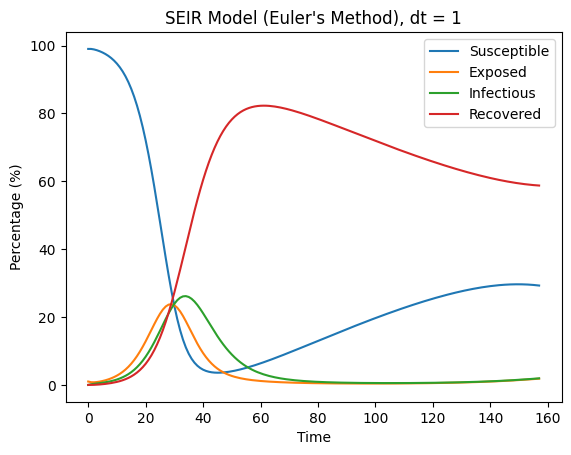

In [415]:
result_euler = np.zeros((len(time), 4)) 
result_euler[0, :] = X0  

for t in range(1, len(time)):
    A = compute_A(result_euler[t-1, :])
    result_euler[t, :] = result_euler[t-1, :] + dt * A @ result_euler[t-1, :]

plt.plot(time, result_euler[:, 0]*100, label='Susceptible')
plt.plot(time, result_euler[:, 1]*100, label='Exposed')
plt.plot(time, result_euler[:, 2]*100, label='Infectious')
plt.plot(time, result_euler[:, 3]*100, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Percentage (%)')
plt.legend()
plt.title(f"SEIR Model (Euler's Method), dt = {dt}")
plt.show()


# RK45 Method 

The Runge-Kutta-Fehlberg 4th and 5th Order (RK45) method is an adaptive numerical technique for solving differential equations, dynamically adjusting the step size to balance accuracy and computational efficiency.

---

## Formula
The state $ X(t) $ is updated over time $ t $ based on 4th-order and 5th-order estimates:

\begin{align}
X_{\text{4th}} &= X_t + c_1 k_1 + c_3 k_3 + c_4 k_4 + c_5 k_5 + c_6 k_6 \\
X_{\text{5th}} &= X_t + d_1 k_1 + d_3 k_3 + d_4 k_4 + d_5 k_5 + d_6 k_6 + d_7 k_7
\end{align}

Where:
- $ k_1 = \Delta t \cdot f(t, X) $
- $ k_2 = \Delta t \cdot f(t + a_2 \Delta t, X + b_{21} k_1) $
- $ k_3 = \Delta t \cdot f(t + a_3 \Delta t, X + b_{31} k_1 + b_{32} k_2) $
- $ k_4 = \Delta t \cdot f(t + a_4 \Delta t, X + b_{41} k_1 + b_{42} k_2 + b_{43} k_3) $
- $ k_5 = \Delta t \cdot f(t + \Delta t, X + b_{51} k_1 + b_{52} k_2 + b_{53} k_3 + b_{54} k_4) $
- $ k_6 = \Delta t \cdot f(t + c_6 \Delta t, X + b_{61} k_1 + b_{62} k_2 + b_{63} k_3 + b_{64} k_4 + b_{65} k_5) $

The coefficients $ a_i, b_{ij}, c_i, $ and $ d_i $ are specific to the Dormand-Prince method.

---

## Steps
1. **Initialize Results**:
   - `result_rk45` stores the SEIR state for each time step.
   - Set the initial state $ X_0 $ and time $ t_0 $.

2. **Iterate with Adaptive Step Size**:
   - At each time step $ t $:
     1. Compute intermediate slopes $ k_1, k_2, \dots, k_6 $ based on the dynamics $ f(t, X) $.
     2. Calculate the 4th and 5th-order estimates $ X_{\text{4th}} $ and $ X_{\text{5th}} $.
     3. Estimate the error as $ \text{error} = \|X_{\text{5th}} - X_{\text{4th}}\| $.
     4. Adjust the step size $ \Delta t $ to control the error:
        - Reduce $ \Delta t $ if the error exceeds the tolerance.
        - Increase $ \Delta t $ if the error is significantly smaller than the tolerance.
     5. Update $ X_{t+1} $ and move to the next step.

3. **Plot Results**:
   - Visualize the dynamics of $ S, E, I, R $ over time.


In [416]:
## Helper function to compute a single step of the RK45 (Dormand-Prince) adaptive method
#
def rk45_step(func, X, t, dt, tol, beta, sigma, gamma, omega, mu, alpha):
    """
    Parameters:
    - func: Function to compute the system matrix (e.g., compute_A).
    - X: Current state vector.
    - t: Current time.
    - dt: Current step size.
    - tol: Tolerance for adaptive step size control.
    - beta, sigma, gamma, omega, mu, alpha: Model parameters.

    Returns:
    - X4: Updated state vector (4th order solution).
    - dt: Adjusted step size for the next iteration.
    - success: Boolean indicating if the step was successful.
    """

    ## Compute intermediate slopes
    #
    k1 = dt * func(X, beta, sigma, gamma, omega, mu, alpha) @ X
    k2 = dt * func(X + 0.2 * k1, beta, sigma, gamma, omega, mu, alpha) @ (X + 0.2 * k1)
    k3 = dt * func(X + 0.3 * k2, beta, sigma, gamma, omega, mu, alpha) @ (X + 0.3 * k2)
    k4 = dt * func(X + 0.8 * k3, beta, sigma, gamma, omega, mu, alpha) @ (X + 0.8 * k3)
    k5 = dt * func(X + dt, beta, sigma, gamma, omega, mu, alpha) @ (X + dt * k4)
    k6 = dt * func(X + 0.875 * k5, beta, sigma, gamma, omega, mu, alpha) @ (X + 0.875 * k5)

    ## 4th and 5th order solutions
    #
    X4 = X + (35 / 384) * k1 + (500 / 1113) * k3 + (125 / 192) * k4 - (2187 / 6784) * k5 + (11 / 84) * k6
    X5 = X + (5179 / 57600) * k1 + (7571 / 16695) * k3 + (393 / 640) * k4 - (92097 / 339200) * k5 + (187 / 2100) * k6 + (1 / 40) * k6

    ## Estimate error
    #
    error = np.linalg.norm(X5 - X4, ord=np.inf)

    ## Adjust step size
    #
    if error > tol:
        dt = dt * max(0.1, 0.8 * (tol / error) ** 0.2) 
        return rk45_step(func, X, t, dt, tol, beta, sigma, gamma, omega, mu, alpha)
    else:
        dt = dt * min(5.0, 0.8 * (tol / error) ** 0.2)
        return X4, dt, True

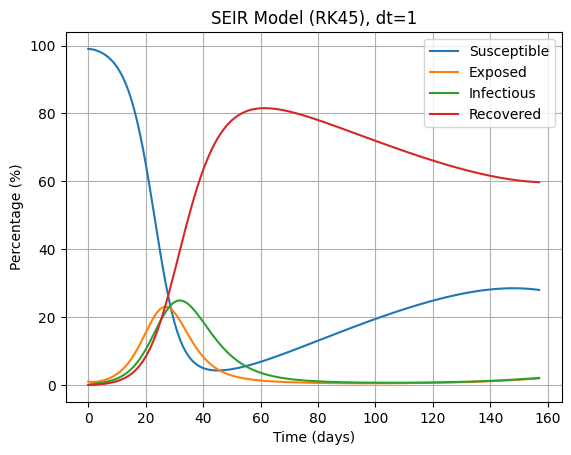

In [417]:
# Solve SEIR using solve_ivp (RK45)
sol = solve_ivp(
    fun=lambda t, X: compute_A(X, beta, sigma, gamma, omega, mu, alpha) @ X,
    t_span=(0, t_max),
    y0=X0,
    t_eval=time,
    method="RK45",
    rtol=1e-6,
    atol=1e-9
)

# Extract solution
result_rk45 = sol.y.T  # Transpose to align with time axis
time_points = sol.t  # Time points

# Plot results
plt.plot(time_points, result_rk45[:, 0] * 100, label='Susceptible')
plt.plot(time_points, result_rk45[:, 1] * 100, label='Exposed')
plt.plot(time_points, result_rk45[:, 2] * 100, label='Infectious')
plt.plot(time_points, result_rk45[:, 3] * 100, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Percentage (%)')
plt.legend()
plt.title(f'SEIR Model (RK45), dt={dt}')
plt.grid()
plt.show()

In [418]:
def simulate_seir(params, time, X0, dt, method):
    """
    Parameters:
    - params: Tuple of model parameters (beta, sigma, gamma, omega, mu, alpha).
    - time: Array of time steps.
    - X0: Initial state vector.
    - dt: Time step for Euler method.
    - method: Numerical method to use ('euler' or 'rk45').

    Returns:
    - results: Array of SEIR state over time.
    """
    beta, sigma, gamma, omega, mu, alpha = params

    if method == 'euler':
        results = np.zeros((len(time), 4))
        results[0, :] = X0

        for t in range(1, len(time)):
            A = compute_A(results[t-1, :], beta, sigma, gamma, omega, mu, alpha)
            results[t, :] = results[t-1, :] + dt * A @ results[t-1, :]

    elif method == 'rk45':
        # Solve using scipy's solve_ivp for fixed evaluation points
        sol = solve_ivp(
            fun=lambda t, X: compute_A(X, beta, sigma, gamma, omega, mu, alpha) @ X,
            t_span=(time[0], time[-1]),
            y0=X0,
            t_eval=time,  # Interpolate to fixed time points
            method="RK45",
            rtol=1e-6,
            atol=1e-9,
        )
        results = sol.y.T  # Transpose to align with Euler output format

    else:
        raise ValueError("Method must be one of 'euler' or 'rk45'.")

    return results

# Stability of Euler vs RK45 method

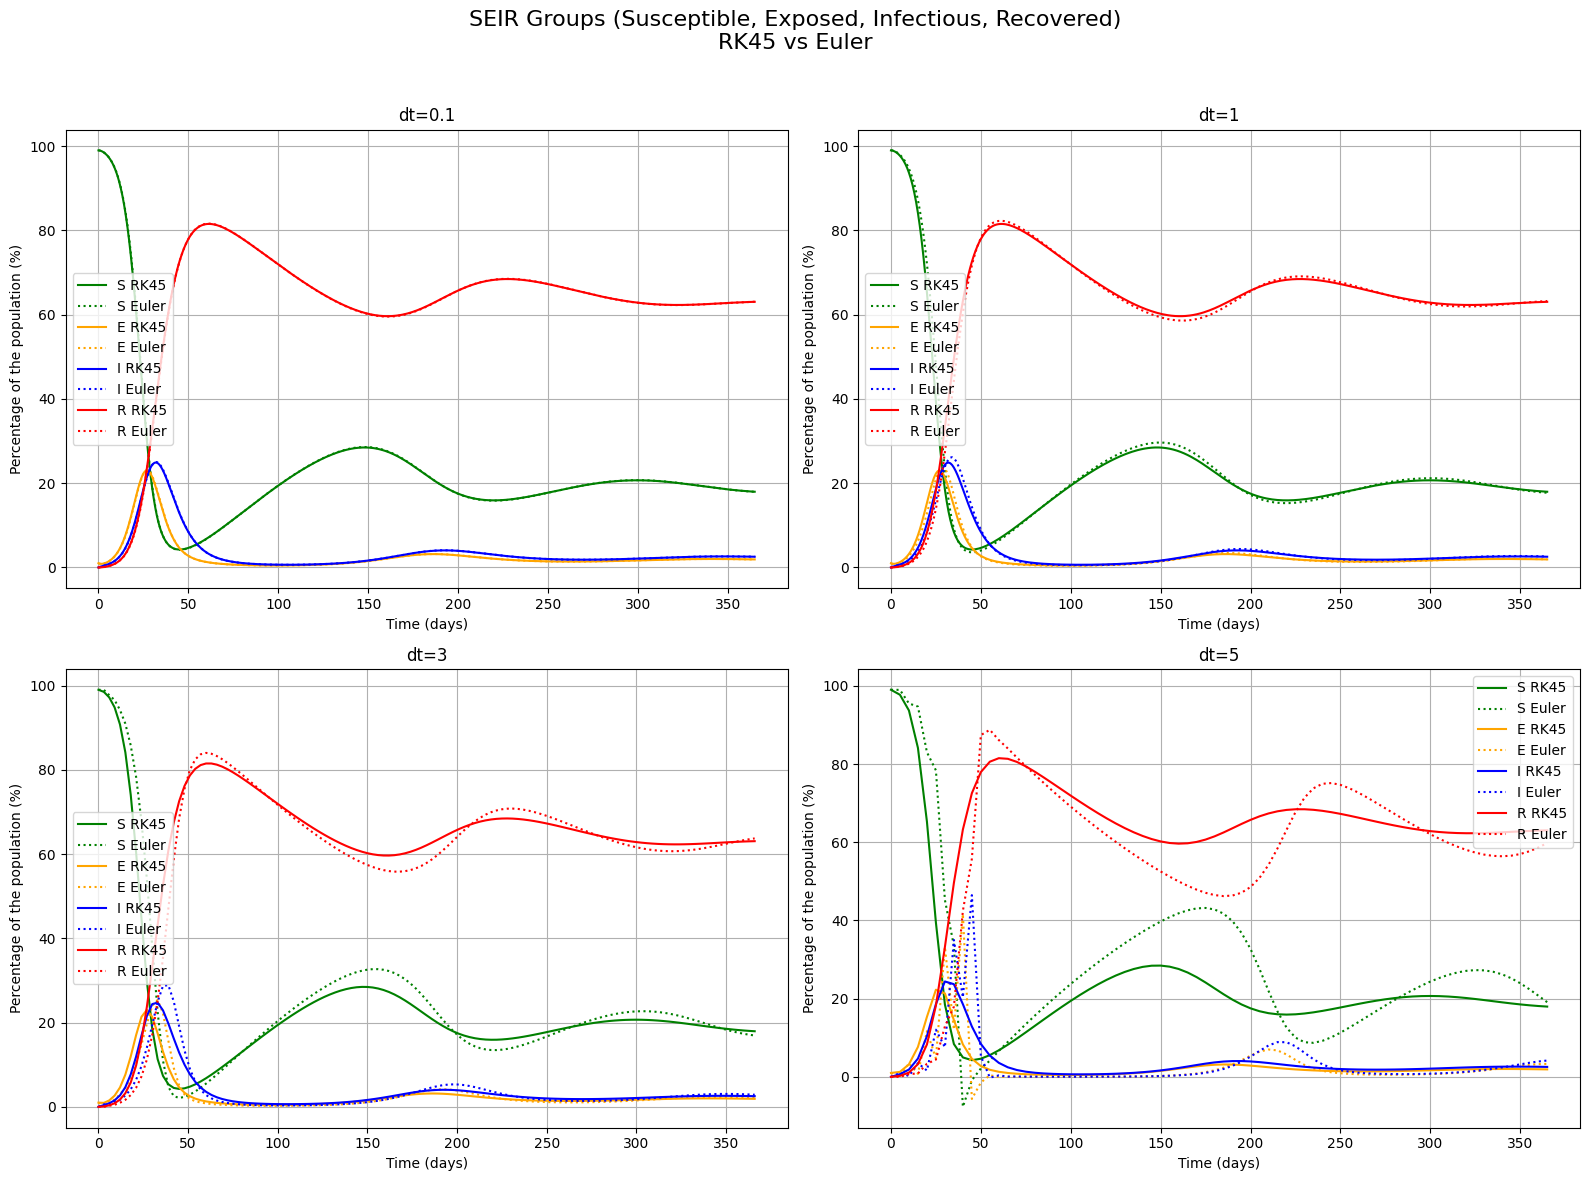

In [419]:
## Variations with different dt
#
params = (beta, sigma, gamma, omega, mu, alpha)

# Initial conditions
S0, E0, I0, R0 = 0.99, 0.01, 0.0, 0.0
X0 = np.array([S0, E0, I0, R0])

t_span = (0, 365)  # a year
dt_values = [0.1, 1, 3, 5]  # Time steps to evaluate

plt.figure(figsize=(16, 12))
plt.suptitle('SEIR Groups (Susceptible, Exposed, Infectious, Recovered)\nRK45 vs Euler', fontsize=16)

for i, dt in enumerate(dt_values, 1):
    time_fixed = np.arange(t_span[0], t_span[1] + dt, dt)
    results_euler = simulate_seir(params, time_fixed, X0, dt, method='euler')
    results_rk45 = simulate_seir(params, time_fixed, X0, dt, method='rk45')
    
    plt.subplot(2, 2, i)
    # Susceptible group (S)
    plt.plot(time_fixed, results_rk45[:, 0] * 100, label="S RK45", linestyle="-", color="green")
    plt.plot(time_fixed, results_euler[:, 0] * 100, label="S Euler", linestyle=":", color="green")
    
    # Exposed group (E)
    plt.plot(time_fixed, results_rk45[:, 1] * 100, label="E RK45", linestyle="-", color="orange")
    plt.plot(time_fixed, results_euler[:, 1] * 100, label="E Euler", linestyle=":", color="orange")
    
    # Infectious group (I)
    plt.plot(time_fixed, results_rk45[:, 2] * 100, label="I RK45", linestyle="-", color="blue")
    plt.plot(time_fixed, results_euler[:, 2] * 100, label="I Euler", linestyle=":", color="blue")
    
    # Recovered group (R)
    plt.plot(time_fixed, results_rk45[:, 3] * 100, label="R RK45", linestyle="-", color="red")
    plt.plot(time_fixed, results_euler[:, 3] * 100, label="R Euler", linestyle=":", color="red")
    
    plt.xlabel("Time (days)")
    plt.ylabel("Percentage of the population (%)")
    plt.title(f"dt={dt}")
    plt.legend()
    plt.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/var/folders/wh/3cghgs_n2k3dkvwmjxz17vy00000gn/T/ipykernel_6354/1260047805.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Stiffness test: High $\sigma$ and $\gamma$')


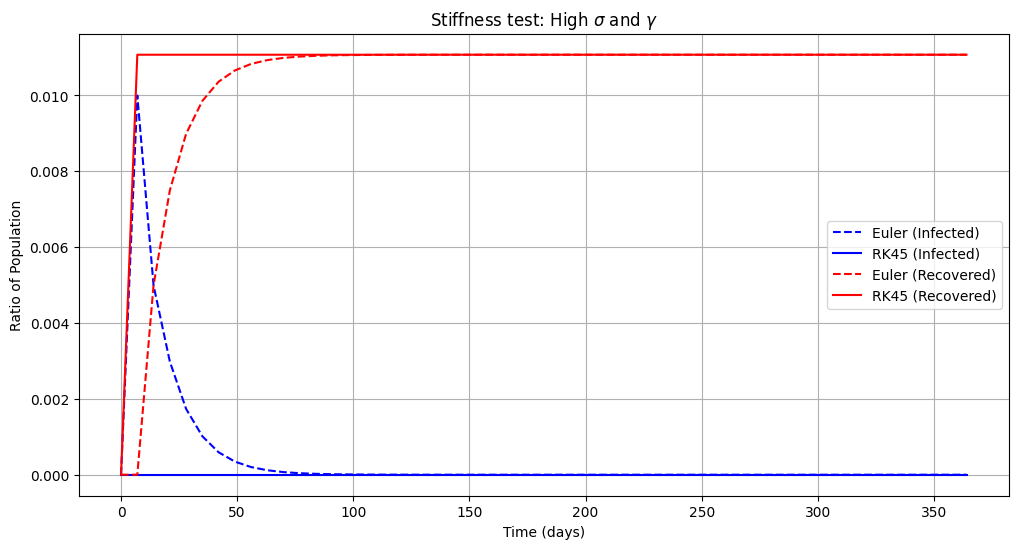

In [420]:
## Stiffness test
#
stiff_params = (0.5, 10, 5, 0, 0, 0.01)  # High sigma and gamma values
time_stiff = np.arange(0, 365, 7) 

results_euler_stiff = simulate_seir(stiff_params, time_stiff, X0, dt=0.1, method='euler')
results_rk45_stiff = simulate_seir(stiff_params, time_stiff, X0, dt=0.1, method='rk45')

plt.figure(figsize=(12, 6))
plt.title('Stiffness test: High $\sigma$ and $\gamma$')

# Infected population (I)
plt.plot(time_stiff, results_euler_stiff[:, 2], label='Euler (Infected)', linestyle="--", color="blue")
plt.plot(time_stiff, results_rk45_stiff[:, 2], label='RK45 (Infected)', linestyle="-", color="blue")

# Recovered population (R)
plt.plot(time_stiff, results_euler_stiff[:, 3], label='Euler (Recovered)', linestyle="--", color="red")
plt.plot(time_stiff, results_rk45_stiff[:, 3], label='RK45 (Recovered)', linestyle="-", color="red")

plt.xlabel("Time (days)")
plt.ylabel("Ratio of Population")
plt.legend()
plt.grid()
plt.show()


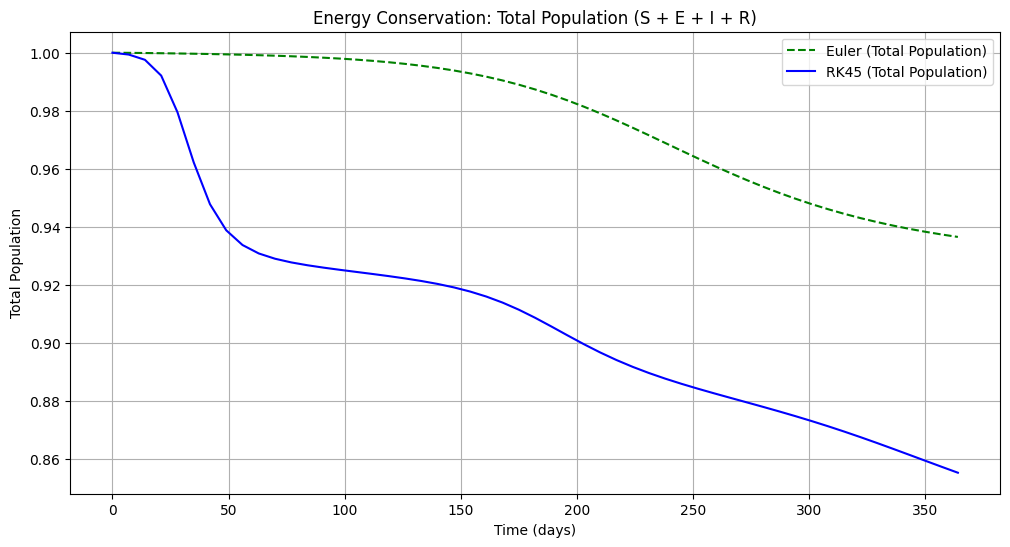

In [422]:
## Energy conservation
#
time_energy = np.arange(0, 365, 7)  # 1 year
# energy_params = (0.5, 10, 5, 0, 0, 0.1)  # High sigma and gamma values

results_euler_energy = simulate_seir(params, time_energy, X0, dt=1, method='euler')
results_rk45_energy = simulate_seir(params, time_energy, X0, dt=1, method='rk45')

# Compute total population for both methods
total_euler = np.sum(results_euler_energy, axis=1)
total_rk45 = np.sum(results_rk45_energy, axis=1)

plt.figure(figsize=(12, 6))
plt.title('Energy Conservation: Total Population (S + E + I + R)')

plt.plot(time_energy, total_euler, label='Euler (Total Population)', linestyle="--", color="green")
plt.plot(time_energy, total_rk45, label='RK45 (Total Population)', linestyle="-", color="blue")

plt.xlabel("Time (days)")
plt.ylabel("Total Population")
plt.legend()
plt.grid()
plt.show()


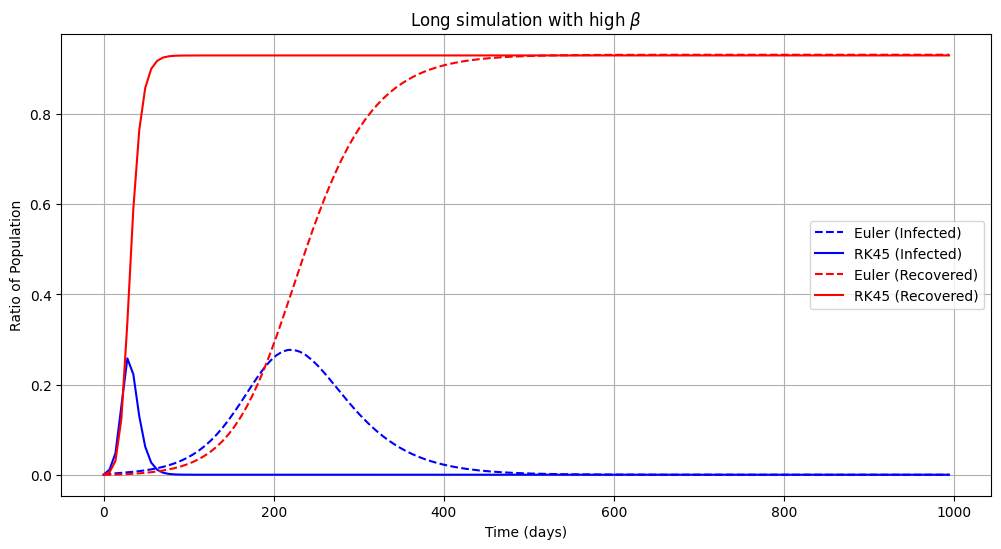

In [423]:
### Long simulation with high beta
# 
varying_params = (0.8, 1 / 5.2, 1 / 7, 0, 0, 0.01)
time_long = np.arange(0, 1000, 7) 

results_euler_long = simulate_seir(varying_params, time_long, X0, dt=1, method='euler')
results_rk45_long = simulate_seir(varying_params, time_long, X0, dt=1, method='rk45')

plt.figure(figsize=(12, 6))
plt.title('Long simulation with high $\\beta$')

# Infected population (I)
plt.plot(time_long, results_euler_long[:, 2], label='Euler (Infected)', linestyle="--", color="blue")
plt.plot(time_long, results_rk45_long[:, 2], label='RK45 (Infected)', linestyle="-", color="blue")

# Recovered population (R)
plt.plot(time_long, results_euler_long[:, 3], label='Euler (Recovered)', linestyle="--", color="red")
plt.plot(time_long, results_rk45_long[:, 3], label='RK45 (Recovered)', linestyle="-", color="red")

plt.xlabel("Time (days)")
plt.ylabel("Ratio of Population")
plt.legend()
plt.grid()
plt.show()


# CA Data


In [424]:
data = pd.read_csv('data/CA_SEIR.csv') ## data in percentage
# data['date'] = pd.date_range(start='2020-03-15', periods=len(data), freq='D')
data.reset_index(inplace=True)
data['date'] = pd.to_datetime(data['date'])
data.head()

,index,Unnamed: 0,date,infectious,recoveredCumulative
0,0,0,2020-03-15,0.001357,0.000109
1,1,1,2020-03-22,0.005048,0.000708
2,2,2,2020-03-29,0.014290,0.003762
3,3,3,2020-04-05,0.020760,0.013775
4,4,4,2020-04-12,0.019092,0.032500


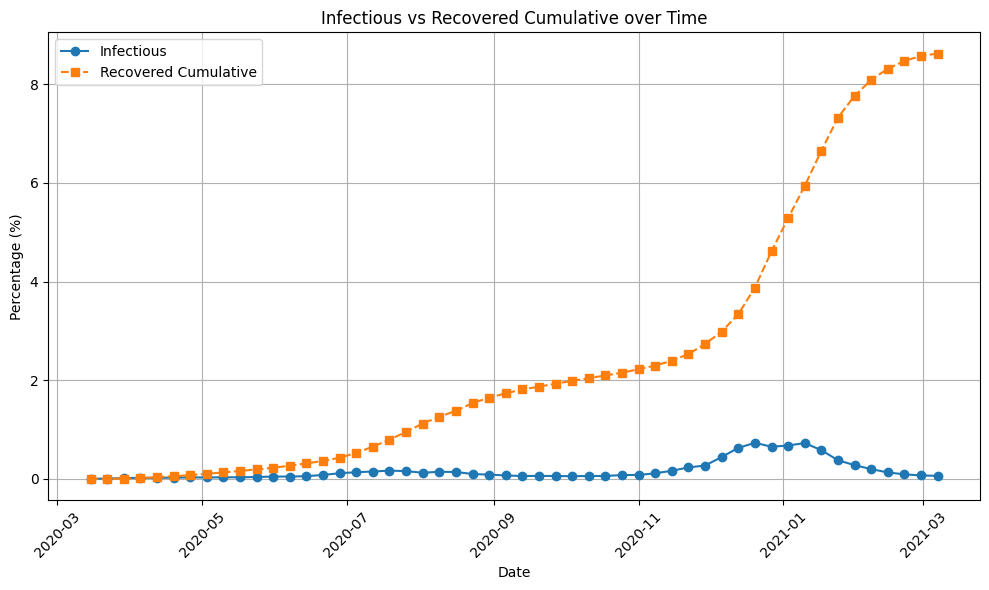

In [425]:
## Plot
#
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['infectious'], label='Infectious', marker='o', linestyle='-')
plt.plot(data['date'], data['recoveredCumulative'], label='Recovered Cumulative', marker='s', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Percentage (%)')
plt.title('Infectious vs Recovered Cumulative over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [426]:
def cost_function(params, data, time, X0, dt, method):
    """
    Calculate the cost for SEIR model parameter optimization.

    Parameters:
    - params: Tuple of model parameters (beta, sigma, gamma, omega, mu, alpha).
    - data: Observed data containing 'infectious' and 'recoveredCumulative'.
    - time: Array of time steps for simulation.
    - X0: Initial state vector.
    - dt: Time step for Euler method.
    - method: Numerical method to use ('euler' or 'rk45').

    Returns:
    - cost: Sum of squared errors between observed and simulated data.
    """
    beta, sigma, gamma, omega, mu, alpha = params

    # Simulate SEIR model
    if method == 'euler':
        results = np.zeros((len(time), 4))
        results[0, :] = X0

        for t in range(1, len(time)):
            A = compute_A(results[t-1, :], beta, sigma, gamma, omega, mu, alpha)
            results[t, :] = results[t-1, :] + dt * A @ results[t-1, :]

        time_points = time

    elif method == 'rk45':
        t = 0
        X = X0
        tol = 1e-6
        results = [X0]
        time_points = [t]

        while t < time[-1]:
            X_next, dt, success = rk45_step(compute_A, X, t, dt, tol, beta, sigma, gamma, omega, mu, alpha)
            if success:
                results.append(X_next)
                time_points.append(t)
                X = X_next
                t += dt

        results = np.array(results)

    else:
        raise ValueError("Invalid method. Choose 'euler' or 'rk45'.")

    # Align simulated time with observed data
    if method == 'euler':
        observed_time_indices = np.arange(0, len(data), 1).astype(int)
    else:
        observed_time_indices = [np.argmin(np.abs(np.array(time_points) - t)) for t in range(len(data))]

    simulated_I = results[observed_time_indices, 2]
    simulated_R = results[observed_time_indices, 3]

    # Calculate error
    observed_I = data['infectious'].iloc[:len(simulated_I)].values
    observed_R = data['recoveredCumulative'].iloc[:len(simulated_R)].values

    infectious_error = np.sum((observed_I - simulated_I) ** 2)
    recovered_error = np.sum((observed_R - simulated_R) ** 2)

    return infectious_error + recovered_error


In [427]:
## Define parameter ranges for grid search
#
beta_range = np.linspace(0.1, 1.0, 5)
sigma_range = np.linspace(0.1, 0.5, 5)
gamma_range = np.linspace(0.1, 0.5, 5)
omega_range = [1/180]  # Assume a fixed value for now
mu_range = [1/(70*365)]  # Assume a fixed value for now
alpha_range = [0.01]  # Assume a fixed value for now

## Initial conditions
#
S0, E0, I0, R0 = 0.99, 0.01, 0, 0
X0 = np.array([S0, E0, I0, R0])

## Time array
#
dt = 1
t_max = (data.shape[0] - 1) * dt
time = np.arange(0, t_max + dt, dt)

## Grid search
#
methods = ['euler', 'rk45']
results = []

start_time = timer.time()

for method in methods:
    best_params = None
    best_cost = float('inf')

    for params in product(beta_range, sigma_range, gamma_range, omega_range, mu_range, alpha_range):
        cost = cost_function(params, data, time, X0, dt, method)
        if cost < best_cost:
            best_cost = cost
            best_params = params

    results.append({
        'method': method,
        'best_params': best_params,
        'best_cost': best_cost
    })

end_time = timer.time()

for result in results:
    print(f"Method: {result['method']}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Cost: {result['best_cost']}")
    print("-" * 40)

print(f"Total computation time: {end_time - start_time:.2f} seconds")

KeyboardInterrupt: 

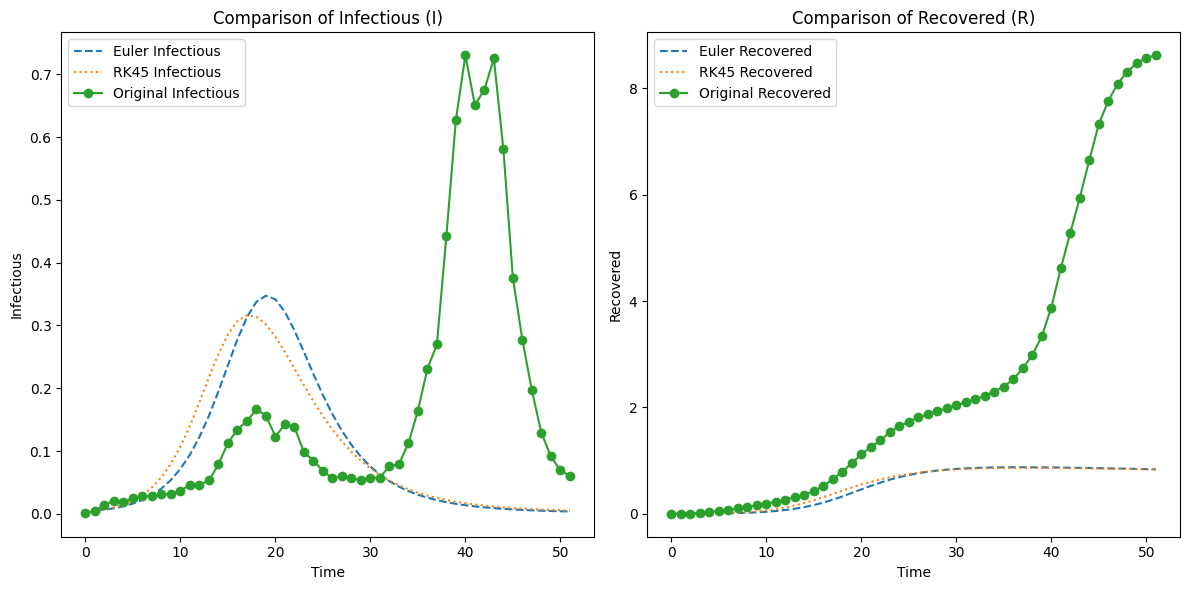

In [337]:
## Extract best parameters for Euler and RK45 methods, from grid search
#
best_params_euler = results[0]['best_params']
best_params_rk45 = results[1]['best_params']

## Simulate using Euler and RK45 methods
#
results_euler = simulate_seir(best_params_euler, time, X0, dt, method='euler')
results_rk45 = simulate_seir(best_params_rk45, time, X0, dt, method='rk45')

## Plot infectious (I) and recovered (R) for Euler, RK45, and original data
#
plt.figure(figsize=(12, 6))

# Infectious
plt.subplot(1, 2, 1)
plt.plot(time, results_euler[:, 2], label="Euler Infectious", linestyle="--")
plt.plot(np.linspace(0, len(data)-1, len(results_rk45)), results_rk45[:, 2], label="RK45 Infectious", linestyle=":")
plt.plot(data['infectious'], label="Original Infectious", marker="o", linestyle="-")
plt.xlabel("Time")
plt.ylabel("Infectious")
plt.title("Comparison of Infectious (I)")
plt.legend()

# Recovered
plt.subplot(1, 2, 2)
plt.plot(time, results_euler[:, 3], label="Euler Recovered", linestyle="--")
plt.plot(np.linspace(0, len(data)-1, len(results_rk45)), results_rk45[:, 3], label="RK45 Recovered", linestyle=":")
plt.plot(data['recoveredCumulative'], label="Original Recovered", marker="o", linestyle="-")
plt.xlabel("Time")
plt.ylabel("Recovered")
plt.title("Comparison of Recovered (R)")
plt.legend()

plt.tight_layout()
plt.show()


# Data from WHO
https://mrc-ide.github.io/global-lmic-reports/

In [428]:
who_data = pd.read_csv('data/WHO-COVID-19-global-daily-data.csv')
who_data = who_data[who_data.Country_code == 'US'][['Date_reported', 'New_cases']].copy()
who_data['Date_reported'] = pd.to_datetime(who_data['Date_reported'])
who_data_filtered = who_data[(who_data['Date_reported'] >= '2021-12-20') & (who_data['Date_reported'] <= '2022-06-01')]
who_data_filtered['New_cases'] = who_data_filtered['New_cases'] / (331000000 / 10)  # Scale to match proportions
who_data_filtered['New_cases'] = who_data_filtered['New_cases'].rolling(window=7).mean()  # Smooth data with a rolling window
who_data_cleaned = who_data_filtered.dropna().set_index('Date_reported')  # Drop NaNs after smoothing
who_data_cleaned.head()

/var/folders/wh/3cghgs_n2k3dkvwmjxz17vy00000gn/T/ipykernel_6354/3091104106.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  who_data_filtered['New_cases'] = who_data_filtered['New_cases'] / (331000000 / 10)  # Scale to match proportions
/var/folders/wh/3cghgs_n2k3dkvwmjxz17vy00000gn/T/ipykernel_6354/3091104106.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  who_data_filtered['New_cases'] = who_data_filtered['New_cases'].rolling(window=7).mean()  # Smooth data with a rolling window


,New_cases
Date_reported,
2021-12-26,0.006117
2021-12-27,0.006239
2021-12-28,0.006710
2021-12-29,0.007566
2021-12-30,0.008370


## Cost Function for Exposed data

In [429]:
def cost_function_exposed(params, observed_data, time, X0, dt, method):
    """
    Parameters:
    - params: Model parameters (beta, sigma, gamma, omega, mu, alpha).
    - observed_data: Actual reported new cases (WHO data).
    - time: Time array for simulation.
    - X0: Initial conditions.
    - dt: Time step size.
    - method: Numerical method ('euler' or 'rk45').

    Returns:
    - cost: Sum of squared differences between simulated E and observed new cases.
    """
    beta, sigma, gamma, omega, mu, alpha = params

    results = simulate_seir(params, time, X0, dt, method)

    ## Extract simulated exposed population (E)
    #
    simulated_exposed = results[:, 1]

    ## Align simulated time with observed data
    #
    observed_dates = observed_data.index
    observed_values = observed_data['New_cases'].values

    ## Interpolating simulated data to match observed dates
    #
    simulated_values = np.interp(
        np.linspace(0, len(simulated_exposed) - 1, len(observed_dates)),
        np.arange(len(simulated_exposed)),
        simulated_exposed
    )

    cost = np.sum((observed_values - simulated_values) ** 2)

    return cost

In [432]:
# Time array
dt = 2
t_max = len(who_data_cleaned) * dt
time = np.arange(0, t_max, dt)

# Define parameter ranges for grid search
beta_range = np.linspace(0.1, 1.0, 10)
sigma_range = np.linspace(0.1, 0.5, 10)
gamma_range = np.linspace(0.1, 0.5, 10)
omega_range = [1 / 180]
mu_range = [1 / (70 * 365)]
alpha_range = [0.01]

# Initial conditions
S0, E0, I0, R0 = 0.99, 0.01, 0, 0
X0 = np.array([S0, E0, I0, R0])

# Perform grid search
methods = ['euler', 'rk45']
results = []

start_time = timer.time()

for method in methods:
    best_params = None
    best_cost = float('inf')

    for params in product(beta_range, sigma_range, gamma_range, omega_range, mu_range, alpha_range):
        try:
            # Compute cost
            cost = cost_function_exposed(params, who_data_cleaned, time, X0, dt, method)
            if cost < best_cost:
                best_cost = cost
                best_params = params
        except Exception as e:
            print(f"Error with parameters {params}: {e}")

    results.append({
        'method': method,
        'best_params': best_params,
        'best_cost': best_cost
    })

end_time = timer.time()

# Display results
for result in results:
    print(f"Method: {result['method']}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Cost: {result['best_cost']}")
    print("-" * 40)

print(f"Total computation time: {end_time - start_time:.2f} seconds")


Method: euler
Best Parameters: (np.float64(0.6), np.float64(0.32222222222222224), np.float64(0.4555555555555556), 0.005555555555555556, 3.913894324853229e-05, 0.01)
Best Cost: 0.00022290280256059147
----------------------------------------
Method: rk45
Best Parameters: (np.float64(0.5), np.float64(0.32222222222222224), np.float64(0.3666666666666667), 0.005555555555555556, 3.913894324853229e-05, 0.01)
Best Cost: 0.00021777451024566273
----------------------------------------
Total computation time: 10.21 seconds


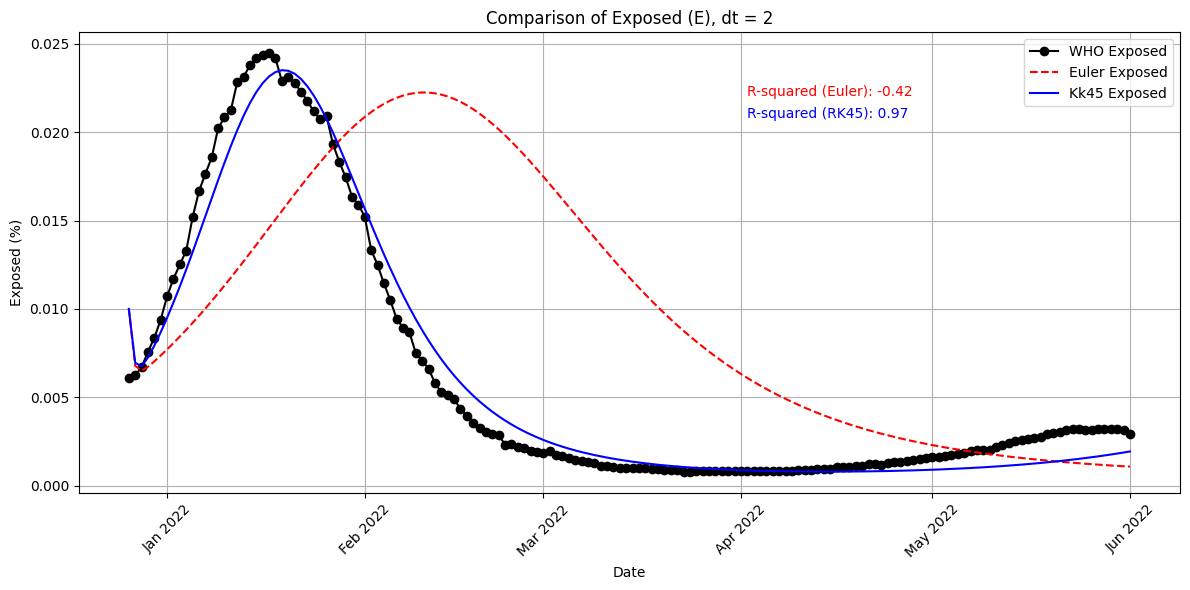

In [433]:
## Extract best parameters from grid search
#
best_params_euler = next(result['best_params'] for result in results if result['method'] == 'euler')
best_params_rk45 = next(result['best_params'] for result in results if result['method'] == 'rk45')

## Simulate using the best parameters
#
results_euler = simulate_seir(best_params_euler, time, X0, dt=1, method='euler')
results_rk45 = simulate_seir(best_params_rk45, time, X0, dt=1, method='rk45')

## Extract exposed (E) population
#
predicted_exposed_euler = results_euler[:, 1]
predicted_exposed_rk45 = results_rk45[:, 1]

## Align simulation time with real data
#
observed_dates = who_data_cleaned.index
observed_values = who_data_cleaned['New_cases'].values

## Interpolate predicted data to match observed dates
#
predicted_exposed_euler_interpolated = np.interp(
    np.linspace(0, len(predicted_exposed_euler) - 1, len(observed_dates)),
    np.arange(len(predicted_exposed_euler)),
    predicted_exposed_euler
)
predicted_exposed_rk45_interpolated = np.interp(
    np.linspace(0, len(predicted_exposed_rk45) - 1, len(observed_dates)),
    np.arange(len(predicted_exposed_rk45)),
    predicted_exposed_rk45
)

# Plot observed vs. predicted exposed data
plt.figure(figsize=(12, 6))
plt.plot(observed_dates, observed_values, label='WHO Exposed', marker='o', linestyle='-', color='black')
plt.plot(observed_dates, predicted_exposed_euler_interpolated, label='Euler Exposed', linestyle='--', color='red')
plt.plot(observed_dates, predicted_exposed_rk45_interpolated, label='Kk45 Exposed', linestyle='-', color='blue')

## Calculate R-squared value
#
r_squared_euler = r2_score(observed_values, predicted_exposed_euler_interpolated)
r_squared_rk45 = r2_score(observed_values, predicted_exposed_rk45_interpolated)

## Readability
#
plt.text(observed_dates[97], observed_values.max()*0.90, f'R-squared (Euler): {r_squared_euler:.2f}', color='red')
plt.text(observed_dates[97], observed_values.max()*0.85, f'R-squared (RK45): {r_squared_rk45:.2f}', color='blue')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every 2 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Month Year"
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.xlabel('Date')
plt.ylabel('Exposed (%)')
plt.title(f'Comparison of Exposed (E), dt = {dt}')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
